In [1]:
import numpy as np
import pandas as pd
import time 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_V1 = pd.read_csv('df_V1.csv')
df_V2 = pd.read_csv('df_V2.csv')

# Data preprocessing - df with no null values
- Standardscaler
- PCA (explained variance 90%)

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def perform_pca(df, target_col_name, desired_variance_ratio=0.90):

    # Drop the 'TARGET' column and store it separately
    target_column = df[target_col_name]
    df = df.drop(columns=[target_col_name])

    # Standardize the data using StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)

    # Perform PCA on the scaled data
    pca = PCA(n_components=desired_variance_ratio, svd_solver='full')  # svd_solver='full' for percentage explained variance
    pca_result = pca.fit_transform(X_scaled)

    # Calculate the actual explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = explained_variance_ratio.cumsum()

    # Determine the number of components needed to achieve the desired variance
    n_components = (cumulative_variance_ratio < desired_variance_ratio).sum() + 1

    # Perform PCA again with the determined number of components
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(X_scaled)

    # Create a DataFrame to store the PCA results
    pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(n_components)])

    # Concatenate the 'TARGET' column back to the PCA DataFrame
    pca_df = pd.concat([pca_df, target_column], axis=1)
    
    return pca_df

In [4]:
pca_df = perform_pca(df_V2, 'TARGET')

In [5]:
print("Dimensions dataset avant réduction PCA: ", df_V2.shape)
print("Dimensions dataset après réduction PCA: ", pca_df.shape)

Dimensions dataset avant réduction PCA:  (307488, 564)
Dimensions dataset après réduction PCA:  (307488, 298)


# Modeling

In [6]:
from sklearn.model_selection import train_test_split

X = pca_df.drop(columns=['TARGET'])
y = pca_df["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
X_train.shape, X_test.shape

((206016, 297), (101472, 297))

## Proof of concept - DummyClassifier

In [8]:
import time
import pickle
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score

In [9]:
from sklearn.dummy import DummyClassifier

# Define the parameter grid with different strategies
dummy_params = {'strategy': ['stratified', 'most_frequent', 'uniform']}

# Initialize an empty list to store cross-validation scores
accuracy_scores = []
roc_auc_scores = []

# Loop through the strategies and perform cross-validation for each
for strategy in dummy_params['strategy']:
    # Create a dummy classifier with the current strategy
    dummy_classifier = DummyClassifier(strategy=strategy, random_state=42)
    
    # Perform cross-validation for accuracy
    accuracy_scores_strategy = cross_val_score(dummy_classifier, X_train, y_train, cv=5, scoring='accuracy')
    
    # Perform cross-validation for ROC AUC
    roc_auc_scores_strategy = cross_val_score(dummy_classifier, X_train, y_train, cv=5, scoring='roc_auc')
    
    # Calculate and store the mean scores for this strategy
    mean_accuracy_strategy = np.mean(accuracy_scores_strategy)
    mean_roc_auc_strategy = np.mean(roc_auc_scores_strategy)
    
    accuracy_scores.append(mean_accuracy_strategy)
    roc_auc_scores.append(mean_roc_auc_strategy)

# Print the mean scores for each strategy
for i, strategy in enumerate(dummy_params['strategy']):
    print(f"Strategy: {strategy}")
    print(f"Mean Accuracy: {accuracy_scores[i]:.3f}")
    print(f"Mean ROC AUC: {roc_auc_scores[i]:.3f}")
    print()

Strategy: stratified
Mean Accuracy: 0.851
Mean ROC AUC: 0.500

Strategy: most_frequent
Mean Accuracy: 0.919
Mean ROC AUC: 0.500

Strategy: uniform
Mean Accuracy: 0.500
Mean ROC AUC: 0.500



In [10]:
# Create and train a dummy classifier with "most_frequent" strategy
dummy_classifier = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_classifier.fit(X_train, y_train)  

DummyClassifier(random_state=42, strategy='most_frequent')

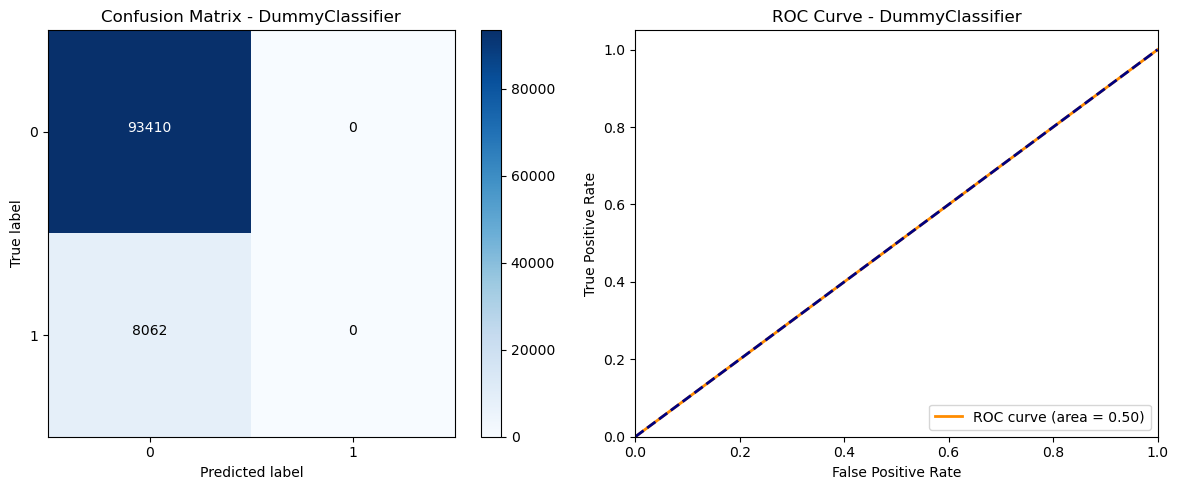

In [11]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
# Plot confusion matrix
y_pred = dummy_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
im = axes[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar(im, ax=axes[0])
    
classes = ["0", "1"]
tick_marks = range(len(classes))
axes[0].set_xticks(tick_marks)
axes[0].set_xticklabels(classes)
axes[0].set_yticks(tick_marks)
axes[0].set_title(f'Confusion Matrix - DummyClassifier')
axes[0].set_yticklabels(classes)
    
for i in range(len(classes)):
    for j in range(len(classes)):
        axes[0].text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
    
axes[0].set_xlabel('Predicted label')
axes[0].set_ylabel('True label')
    
# Calculate and plot ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

    
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title(f'ROC Curve - DummyClassifier')
axes[1].legend(loc="lower right")
    
plt.tight_layout()
plt.show()

## Different models

TARGET variable description: 
- 1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 
- 0 - all other cases

- True Positives (TP) indicate correct predictions of high-risk applicants with payment difficulties (TARGET=1).
- True Negatives (TN) show correct predictions of low-risk applicants without payment difficulties (TARGET=0).
- False Positives (FP) represent incorrect predictions of high-risk applicants who are actually low-risk, potentially causing unnecessary rejections (TARGET=1).
- False Negatives (FN) indicate incorrect predictions of low-risk applicants who are actually high-risk, possibly leading to loans granted to applicants who later default (TARGET=0).

**custom_scorer**: 
- w_fp = 1 Weight for false positives
- w_fn = 10 Weight for false negatives
- **max_cost_coef** = max(w_fn, w_fp) determines the scaling factor based on the weight of the more important misclassification type (either FP or FN)
- **max_cost** calculates a maximum possible cost by multiplying the total number of samples by the maximum cost coefficient. This represents the worst-case scenario cost (model makes all predictions as FN)
- **score** indicates how well the model performs by comparing the cost of misclassifications to the worst-case scenario cost, with higher scores denoting better performance

In [12]:
def custom_scorer(y_true, y_pred):
    w_fp = 1  # Weight for false positives
    w_fn = 10  # Weight for false negatives
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    n_samples = tn + fp + fn + tp  # Total number of samples
    
    wfp = fp * w_fp
    wfn = fn * w_fn
    
    max_cost_coef = max(w_fn, w_fp)
    
    max_cost = n_samples * max_cost_coef
    
    score = (max_cost - (wfp + wfn)) / max_cost
    
    return score

# Create a callable scorer using make_scorer
custom_score = make_scorer(custom_scorer, greater_is_better=True)

In [13]:
import mlflow
import mlflow.sklearn

In [14]:
from sklearn.metrics import roc_auc_score, accuracy_score

def grid_search_and_fit(model, param_grid, X_train, y_train, X_test, y_test, model_name):
        
    """
    Perform grid search to find the best hyperparameters for a model, train the best model, 
    and return the best score along with the training time in seconds.
    Also, perform cross-validation on the test set and return the test scores.

    Parameters:
    - model: The model to be trained and tuned.
    - param_grid: Dictionary with parameter names as keys and lists of parameter settings to try as values.
    - X_train: The training data features.
    - y_train: The training data target.
    - X_test: The test data features.
    - y_test: The test data target.
    - model_name: A unique name or identifier for the model.

    Returns:
    - best_score: The best cross-validated score on the training set.
    - best_params: The best hyperparameters.
    - training_time_seconds: The time taken to train the best model on the training set in seconds.
    - test_scores: Dictionary containing test scores (balanced_accuracy and ROC AUC) obtained from cross-validation on the test set.
    """
    with mlflow.start_run(run_name=model_name):
    
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring=custom_score)
        start_time = time.time()
        grid_search.fit(X_train, y_train)
        end_time = time.time()

        best_score = round(grid_search.best_score_, 3)
        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_

        training_time_seconds = round(end_time - start_time)

        mlflow.log_params(best_params)
        mlflow.log_metric("Best custom_score", best_score)
        mlflow.log_metric("TrainingTimeInSeconds", training_time_seconds)

        print(f"GridSearchCV results for {best_model}")
        print(f"\nBest custom_score: {best_score:.3f}")
        print("Best Parameters:")
        for param, value in best_params.items():
            print(f"  {param}: {value}")
        print(f"Training time on Training Set (seconds): {training_time_seconds}")

        # Calculate custom score on the test set
        y_pred = best_model.predict(X_test)
        custom_score_test = custom_scorer(y_test, y_pred)

        # Evaluate the model on the test set (accuracy, roc_auc)
        y_pred_prob = best_model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        accuracy = accuracy_score(y_test, y_pred)

        # Create a list of test scores
        test_scores = [custom_score_test, roc_auc, accuracy]

        mlflow.log_metric("Custom Score", custom_score_test)
        mlflow.log_metric("ROC AUC", roc_auc)
        mlflow.log_metric("Accuracy", accuracy)

        # Print the results
        print("\nTest Scores:")
        print(f'ROC AUC on the test set: {roc_auc:.4f}')
        print(f'Accuracy on the test set: {accuracy:.4f}')
        print(f'custom_score on the test set: {custom_score_test:.4f}')

        # Save the trained model using pickle
        model_filename = f"{model_name}_model.pkl"  # Include the model name in the filename
        with open(model_filename, 'wb') as model_file:
            pickle.dump(best_model, model_file)

        print(f"\nModel saved: {model_filename}")

        # Save the trained model using MLflow
        mlflow.sklearn.log_model(best_model, f"{model_name}_model")

        mlflow.end_run()

    # Extract and return the test scores
    return best_model, best_score, best_params, training_time_seconds, test_scores

In [15]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

def plot_evaluation_metrics(model, X_test, y_test, model_name):
    """
    Plot confusion matrix and ROC/AUC curve for a binary classification model.

    Parameters:
    - model: The trained classification model.
    - X_test: The test data features.
    - y_test: The test data target.
    - model_name: The name of the model for labeling the plots.

    Returns:
    - None (displays plots).
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot confusion matrix
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    im = axes[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[0].set_title(f'Confusion Matrix - {model_name}')
    plt.colorbar(im, ax=axes[0])
    
    classes = ["0", "1"]
    tick_marks = range(len(classes))
    axes[0].set_xticks(tick_marks)
    axes[0].set_xticklabels(classes)
    axes[0].set_yticks(tick_marks)
    axes[0].set_yticklabels(classes)
    
    for i in range(len(classes)):
        for j in range(len(classes)):
            axes[0].text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
    
    axes[0].set_xlabel('Predicted label')
    axes[0].set_ylabel('True label')
    
    # Calculate ROC curve and AUC
    y_prob = model.predict_proba(X_test)[:, 1]  # predict_proba
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)  # Calculate ROC curve
    roc_auc = auc(fpr, tpr)  # Calculate AUC
    
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title(f'ROC Curve - {model_name}')
    axes[1].legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()


### Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression 
logistic_regression = LogisticRegression(max_iter=650)
logistic_params = {'C': [0.01, 0.1, 1], 
                   'class_weight': ['balanced']}

GridSearchCV results for LogisticRegression(C=1, class_weight='balanced', max_iter=650)

Best custom_score: 0.946
Best Parameters:
  C: 1
  class_weight: balanced
Training time on Training Set (seconds): 123

Test Scores:
ROC AUC on the test set: 0.7473
Accuracy on the test set: 0.6867
custom_score on the test set: 0.9454

Model saved: LogisticRegression_model.pkl


C:\Users\Madara\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


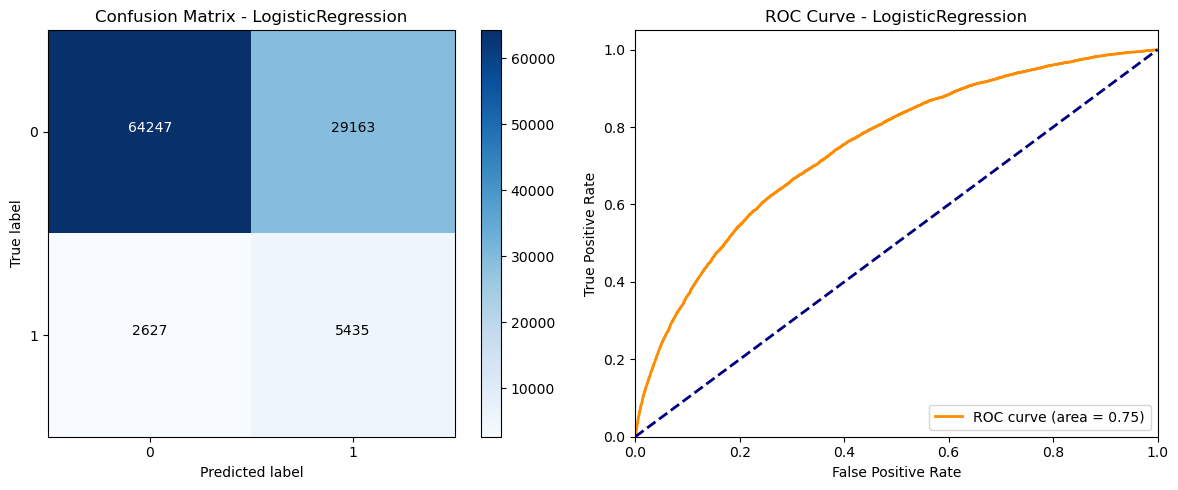

In [17]:
lr_best_model, lr_best_score, lr_best_params, lr_training_time_seconds, lr_test_scores = grid_search_and_fit(logistic_regression, logistic_params, X_train, y_train, X_test, y_test, model_name="LogisticRegression")
plot_evaluation_metrics(lr_best_model, X_test, y_test, "LogisticRegression")

### BayesianClassifier

In [18]:
from sklearn.naive_bayes import GaussianNB

BayesianClassifier = GaussianNB()
bayesian_params = {'var_smoothing': [1e-9, 1e-8, 1e-7],
                  'priors' : [None]}

GridSearchCV results for GaussianNB()

Best custom_score: 0.920
Best Parameters:
  priors: None
  var_smoothing: 1e-09
Training time on Training Set (seconds): 18

Test Scores:
ROC AUC on the test set: 0.6356
Accuracy on the test set: 0.8716
custom_score on the test set: 0.9225

Model saved: BayesianClassifier_model.pkl


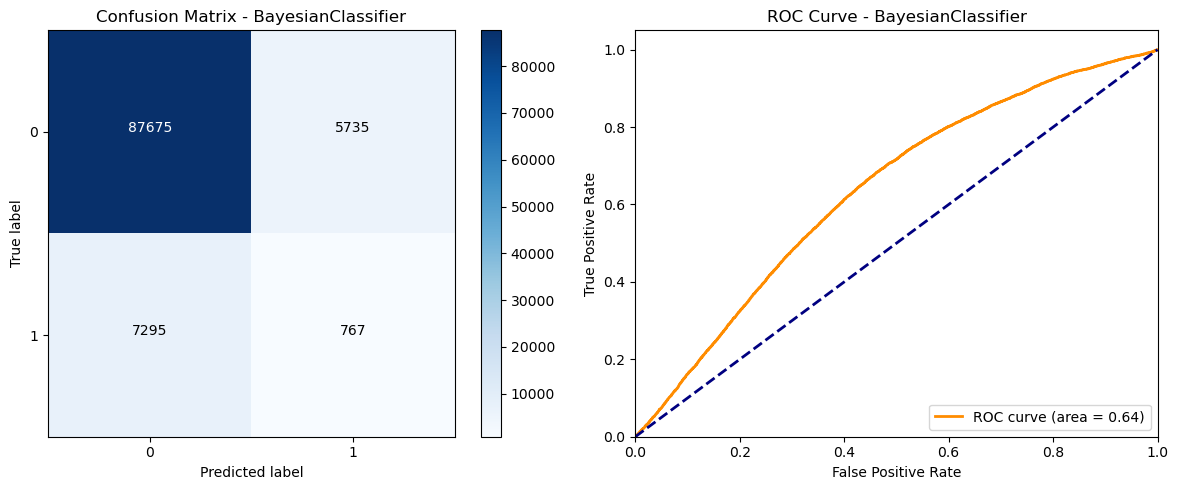

In [19]:
BC_best_model, BC_best_score, BC_best_params, BC_training_time_seconds, BC_test_scores = grid_search_and_fit(
    BayesianClassifier, bayesian_params, X_train, y_train, X_test, y_test, model_name="BayesianClassifier")
plot_evaluation_metrics(BC_best_model, X_test, y_test, "BayesianClassifier")

### LGBMClassifier

In [20]:
from lightgbm import LGBMClassifier
LGBMClassifier = LGBMClassifier(verbosity=-1) # verbosity = silent mode
#LGBMC_params = {
    #'boosting_type': ['gbdt', 'dart', 'goss'],  # Different boosting types
    #'learning_rate': [0.001, 0.01, 0.1],
    #'n_estimators': [100, 200, 300],  # Number of boosting rounds
    #'class_weight': ['balanced'],  # Class weights (set to 'balanced' for imbalance handling)
#}

In [21]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

In [23]:
LGBMC_params = {
    'boosting_type': ['dart'],
    'learning_rate': [0.1],
    'n_estimators': [300], 
    'class_weight': ['balanced']
}

GridSearchCV results for LGBMClassifier(boosting_type='dart', class_weight='balanced', n_estimators=300,
               verbosity=-1)

Best custom_score: 0.944
Best Parameters:
  boosting_type: dart
  class_weight: balanced
  learning_rate: 0.1
  n_estimators: 300
Training time on Training Set (seconds): 281

Test Scores:
ROC AUC on the test set: 0.7327
Accuracy on the test set: 0.7176
custom_score on the test set: 0.9439

Model saved: LGBMClassifier_model.pkl


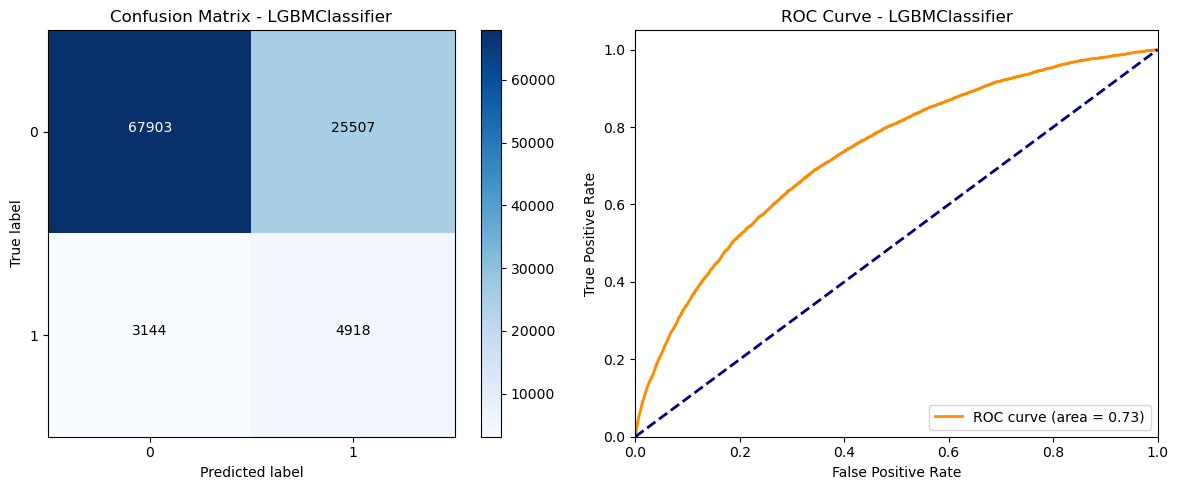

In [24]:
LGBM_best_model, LGBM_best_score, LGBM_best_params, LGBM_training_time_seconds, LGBM_test_scores = grid_search_and_fit(LGBMClassifier, LGBMC_params, X_train, y_train, X_test, y_test, model_name="LGBMClassifier")
plot_evaluation_metrics(LGBM_best_model, X_test, y_test, "LGBMClassifier")

### LGBMClassifier with nulls

In [25]:
import re

def clean_feature_name(feature_name):
    cleaned_name = re.sub(r'[^a-zA-Z0-9_]', '_', feature_name)
    return cleaned_name

# Apply clean_feature_name to all column names in df_V1
df_V1 = df_V1.rename(columns={col: clean_feature_name(col) for col in df_V1.columns})

In [26]:
count_rows_with_infinite = (df_V1.isin([np.inf, -np.inf])).any(axis=1).sum()
count_rows_with_infinite

19

In [27]:
df_V1 = df_V1[~df_V1.isin([np.inf, -np.inf]).any(axis=1)]

In [28]:
X1 = df_V1.drop(columns=['TARGET'])
y1 = df_V1["TARGET"]

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.33, random_state=42)

GridSearchCV results for LGBMClassifier(boosting_type='dart', class_weight='balanced', n_estimators=300,
               verbosity=-1)

Best custom_score: 0.950
Best Parameters:
  boosting_type: dart
  class_weight: balanced
  learning_rate: 0.1
  n_estimators: 300
Training time on Training Set (seconds): 279

Test Scores:
ROC AUC on the test set: 0.7755
Accuracy on the test set: 0.7301
custom_score on the test set: 0.9496

Model saved: LGBMClassifier_V2_model.pkl


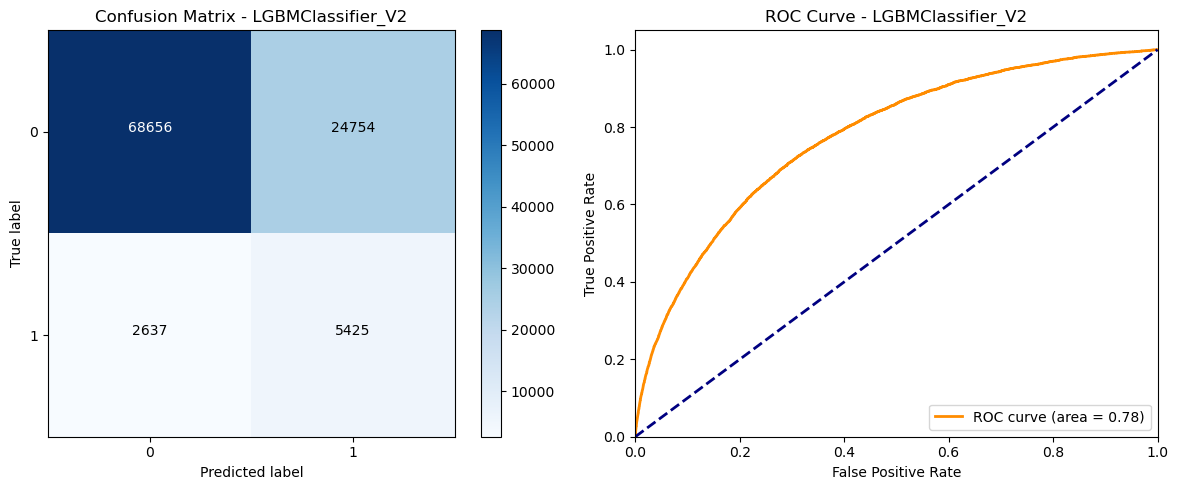

In [29]:
LGBM_best_model_V1, LGBM_best_score_V1, LGBM_best_params_V1, LGBM_training_time_seconds_V1, LGBM_test_scores_V1 = grid_search_and_fit(LGBMClassifier, LGBMC_params, X_train1, y_train1, X_test1, y_test1, model_name="LGBMClassifier_V2")
plot_evaluation_metrics(LGBM_best_model_V1, X_test1, y_test1, "LGBMClassifier_V2")

# Comparison of models

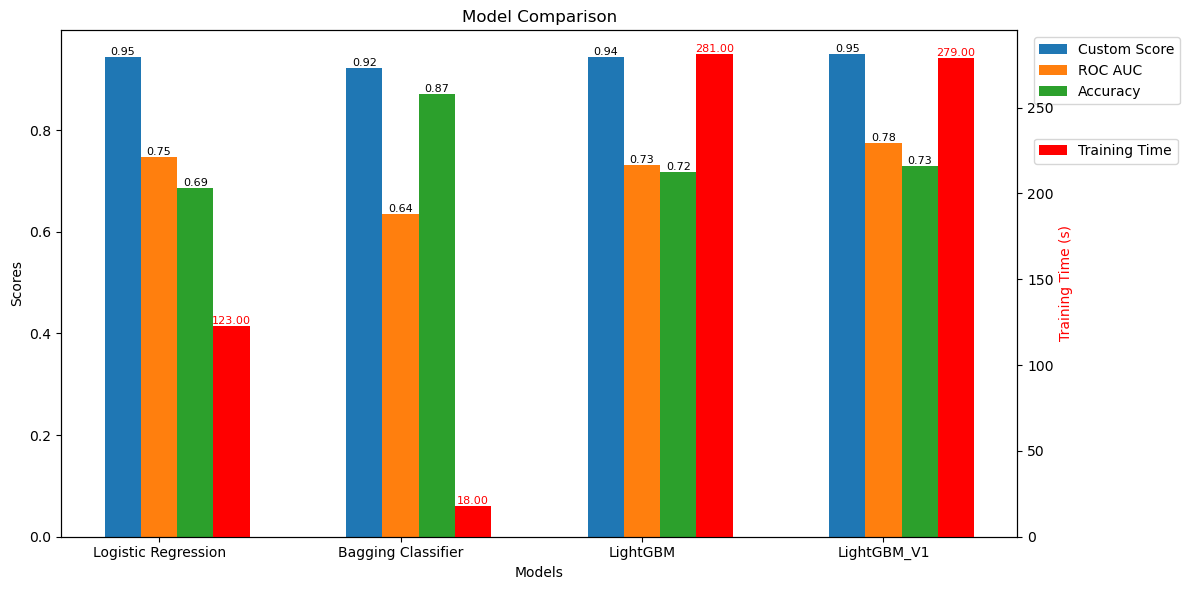

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Test scores for each model
models = ["Logistic Regression", "Bagging Classifier", "LightGBM", "LightGBM_V1"]
custom_scores = [lr_test_scores[0], BC_test_scores[0], LGBM_test_scores[0], LGBM_test_scores_V1[0]]
roc_auc_scores = [lr_test_scores[1], BC_test_scores[1], LGBM_test_scores[1], LGBM_test_scores_V1[1]]
accuracy_scores = [lr_test_scores[2], BC_test_scores[2], LGBM_test_scores[2], LGBM_test_scores_V1[2]]

# Training time for each model
training_time = [lr_training_time_seconds, BC_training_time_seconds, LGBM_training_time_seconds, LGBM_training_time_seconds_V1]

# Create subplots with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Set the width of the bars
bar_width = 0.15

# Position of bars on x-axis
index = np.arange(len(models))

# Create bar plots for custom score, ROC AUC, and accuracy on the first y-axis
bar1 = ax1.bar(index, custom_scores, bar_width, label='Custom Score')
bar2 = ax1.bar(index + bar_width, roc_auc_scores, bar_width, label='ROC AUC')
bar3 = ax1.bar(index + 2 * bar_width, accuracy_scores, bar_width, label='Accuracy')

# Set the labels and title for the first y-axis
ax1.set_xlabel('Models')
ax1.set_ylabel('Scores')
ax1.set_title('Model Comparison')

# Set x-axis tick positions and labels
ax1.set_xticks(index + bar_width)
ax1.set_xticklabels(models)

# Create a twin axes for the second y-axis
ax2 = ax1.twinx()

# Create a bar plot for training time on the second y-axis
bar4 = ax2.bar(index + 3 * bar_width, training_time, bar_width, label='Training Time', color='r')

# Set the label for the second y-axis
ax2.set_ylabel('Training Time (s)', color='r')

# Display the legend for both y-axes outside the graph area
ax1_legend = ax1.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
ax2_legend = ax2.legend(loc='upper left', bbox_to_anchor=(1.01, 0.8))

# Annotate the bars with their respective values (rounded to 2 decimal places)
for i in index:
    ax1.text(i, custom_scores[i], f'{custom_scores[i]:.2f}', ha='center', va='bottom', fontsize=8)
    ax1.text(i + bar_width, roc_auc_scores[i], f'{roc_auc_scores[i]:.2f}', ha='center', va='bottom', fontsize=8)
    ax1.text(i + 2 * bar_width, accuracy_scores[i], f'{accuracy_scores[i]:.2f}', ha='center', va='bottom', fontsize=8)
    ax2.text(i + 3 * bar_width, training_time[i], f'{training_time[i]:.2f}', ha='center', va='bottom', fontsize=8, color='r')

# Show the bar chart
plt.tight_layout()
plt.show()


Base code: https://www.kaggle.com/code/ashishpatel26/feature-importance-of-lightgbm/notebook 

## Feature importance (global)

Global importance assesses the overall significance of each feature across the entire dataset, helping to identify which features are generally important for a machine learning model's predictions.

## LIGHTGBM

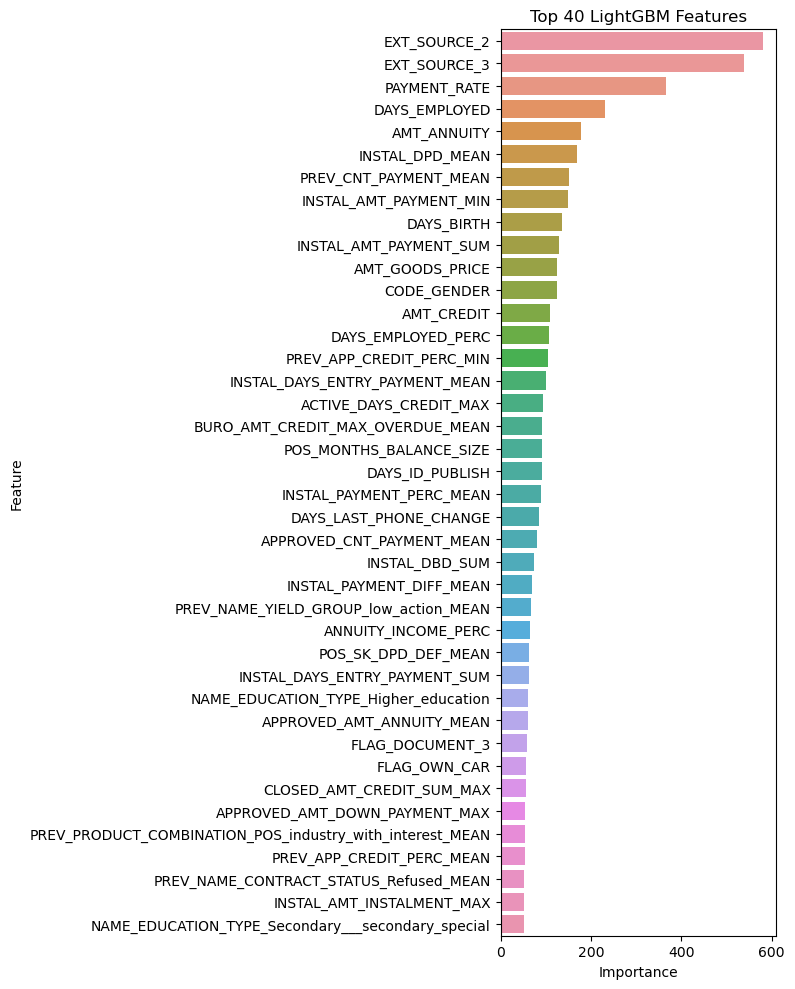

In [46]:
# Calculate feature importances
feature_imp = pd.DataFrame(sorted(zip(LGBM_best_model_V1.feature_importances_, X_train1.columns), reverse=True), columns=['Importance','Feature'])

# Select the top 40 important features
top_40_features = feature_imp.head(40)

# Plot feature importances
plt.figure(figsize=(8, 10))
sns.barplot(x="Importance", y="Feature", data=top_40_features.sort_values(by="Importance", ascending=False))
plt.title('Top 40 LightGBM Features')
plt.tight_layout()
plt.savefig('lgbm_importances_top_40.png')
plt.show()

In [47]:
import shap
explainer = shap.TreeExplainer(LGBM_best_model_V1)
shap_values = explainer.shap_values(X1)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [48]:
shap.summary_plot(shap_values, X1)

MemoryError: Unable to allocate 2.58 GiB for an array with shape (2, 307488, 563) and data type float64

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X1.iloc[0,:])

## Logistic regression

In [49]:
# compute SHAP values
explainer = shap.Explainer(lr_best_model, X_train)
shap_values = explainer(X_train)

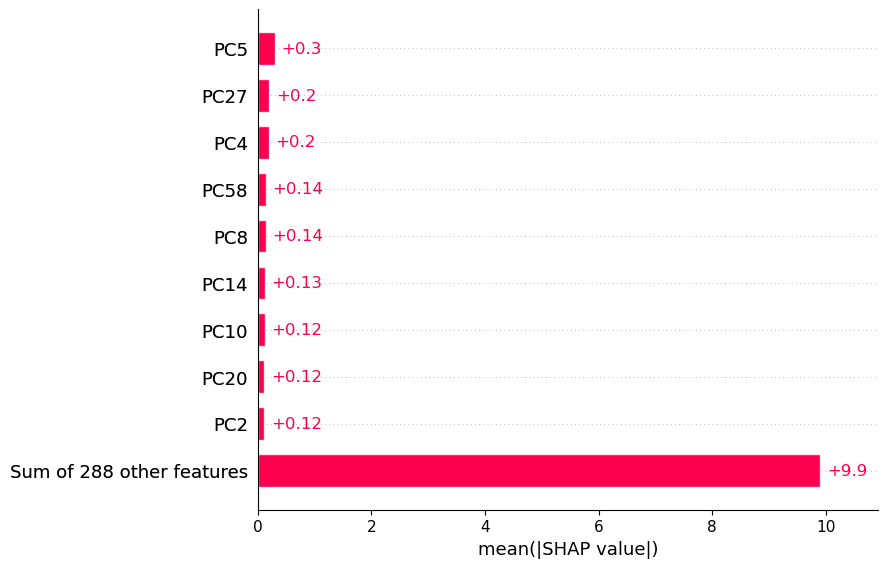

In [64]:
shap.plots.bar(shap_values)

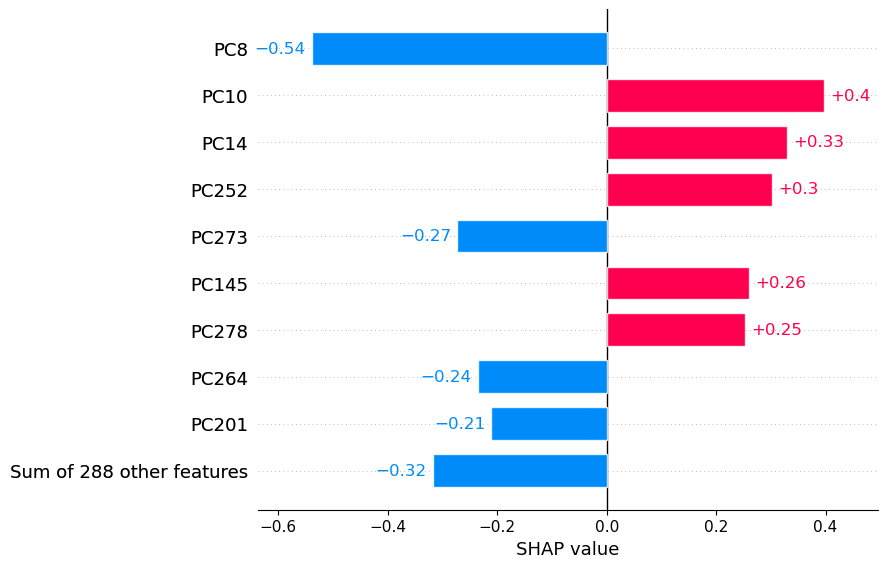

In [65]:
shap.plots.bar(shap_values[0])